In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
import random 
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input
from tensorflow.keras.layers import Input
from keras.layers import Reshape
from tensorflow.keras.layers import Reshape
from keras.layers import Bidirectional
from tensorflow.keras.layers import Bidirectional
from keras.layers import LSTM
from tensorflow.keras.layers import LSTM
from keras.models import Model
from tensorflow.keras.models import Model
from keras.layers import Lambda
from tensorflow.keras.layers import Lambda
from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam


In [3]:
import os
import PIL
train=os.listdir('Desktop/rename')

FileNotFoundError: [Errno 2] No such file or directory: 'Desktop/rename'

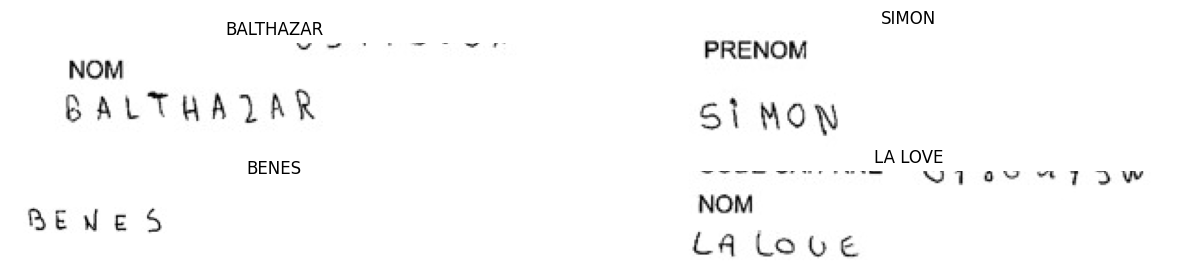

In [2]:
train = pd.read_csv('Desktop/archive/written_name_train_v2.csv')
valid = pd.read_csv('Desktop/archive/written_name_validation_v2.csv')
plt.figure(figsize=(15, 10))

#using plt subplot and pandas displaying the text for the image
for i in range(4):
    ax = plt.subplot(2,2, i+1)
    img_dir = 'Desktop/archive/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [3]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

In [4]:
train['IDENTITY']

0             BALTHAZAR
1                 SIMON
2                 BENES
3               LA LOVE
4                DAPHNE
              ...      
330956            LENNY
330957          TIFFANY
330958    COUTINHO DESA
330959           MOURAD
330960          HELOISE
Name: IDENTITY, Length: 330396, dtype: object

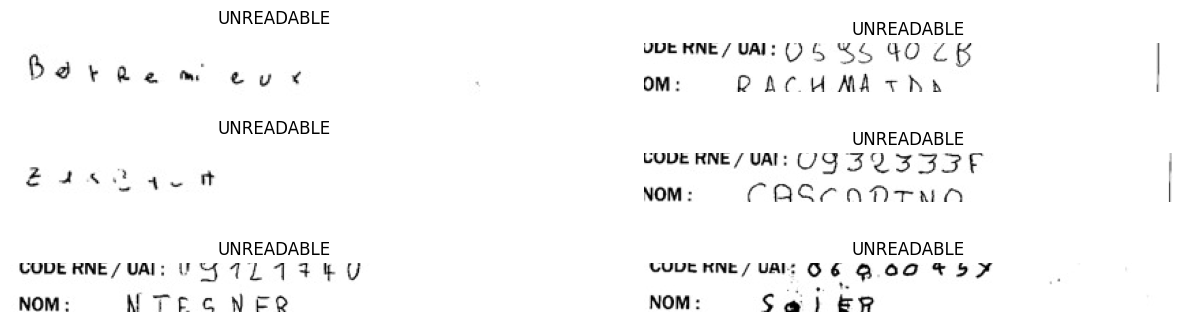

In [5]:
#finding all the unreadable images
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(3, 2, i+1)
    img_dir = 'Desktop/archive/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [6]:
#dropping all unreadable images
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [7]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [8]:
#resetting the index after dropping the images
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

In [9]:
train.shape[0]/128

2580.421875

In [15]:
#resizing the image 
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [16]:
train.size

660588

In [17]:
valid.size

82560

In [18]:
valid_size=3000

In [19]:
valid_x = []

for i in range(valid_size):
    img_dir = 'Desktop/archive/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)


In [20]:
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [21]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels
batch_size = 128

def label_to_num(label):
    label_num = []
    for ch in label:
        
            label_num.append(alphabets.find(ch) if alphabets.find(ch)!=-1 else alphabets.find('-'))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [22]:
name = 'JANAV'
print(name, '\n',label_to_num(name))

JANAV 
 [ 9  0 13  0 21]


In [23]:
train.shape

(330294, 2)

In [24]:
 len(train.iloc[39128]['IDENTITY'])

34

In [25]:
directory = '/Desktop/archive/train_v2/train/'

def image_generator(path):
        for row, val in  train.iterrows(): #need improvement
#             try:
                img_dir = os.path.join(path, val['FILENAME'])
                image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
                image = preprocess(image)[..., np.newaxis]
        #         print(image.shape)
                image = image/255.
                if image.shape !=(256,64,1):
                    break
        #         train_label_len[i] = len(train.loc[i, 'IDENTITY'])
                if (len(val['IDENTITY'])>max_str_len):
                    continue
                labels = label_to_num(val['IDENTITY'])    
                yield (image, labels)
#             except Exception as e:
#                 continue

In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [27]:
# # dataset = tf.data.Dataset.from_generator(lambda: image_generator(directory), output_types=())
# directory = '/kaggle/input/handwriting-recognition/train_v2/train/'

dataset = tf.data.Dataset.from_generator(lambda: image_generator(directory), (tf.float32, tf.float32))# , ([256, 64,1], [None]))
def foo(*val):
    xl = val[0]
    lab = val[1]
    lab_len = len(lab)
    one_pad = -tf.ones((max_str_len - lab_len))#*(-1)
    y = tf.concat([lab, one_pad], -1)
    
    return xl, y, [num_of_timestamps-2], [lab_len], [0]
                  
dataset = dataset.map(foo).batch(batch_size)
dataset_final = dataset.map(lambda *x: (x[0:-1],x[-1])).prefetch(AUTOTUNE)

Metal device set to: Apple M1 Pro


In [28]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY']) 

In [29]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((num_of_timestamps, 1024)), name='reshape')(inner)
inner = Dense(num_of_timestamps, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 64, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

In [30]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [31]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [32]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

In [33]:
model_final.fit(dataset_final, epochs=8,verbose=1)

Epoch 1/8


2023-08-23 20:04:49.310724: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz



systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



[ WARN:0@47.677] global loadsave.cpp:244 findDecoder imread_('/Desktop/archive/train_v2/train/TRAIN_00001.jpg'): can't open/read file: check file path/integrity
2023-08-23 20:04:51.013846: W tensorflow/core/framework/op_kernel.cc:1818] UNKNOWN: AttributeError: 'NoneType' object has no attribute 'shape'
Traceback (most recent call last):

  File "/Users/janavbhasin/miniconda3/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)

  File "/Users/janavbhasin/miniconda3/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/Users/janavbhasin/miniconda3/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/var/folders/8t/5ntwdmc123s_h4q2k196j_d40000gn/T/ipykernel_23343/556018634.py", line 8, in image_generator
    image = preproces

UnknownError: Graph execution error:

2 root error(s) found.
  (0) UNKNOWN:  AttributeError: 'NoneType' object has no attribute 'shape'
Traceback (most recent call last):

  File "/Users/janavbhasin/miniconda3/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)

  File "/Users/janavbhasin/miniconda3/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/Users/janavbhasin/miniconda3/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/var/folders/8t/5ntwdmc123s_h4q2k196j_d40000gn/T/ipykernel_23343/556018634.py", line 8, in image_generator
    image = preprocess(image)[..., np.newaxis]

  File "/var/folders/8t/5ntwdmc123s_h4q2k196j_d40000gn/T/ipykernel_23343/1471328267.py", line 3, in preprocess
    (h, w) = img.shape

AttributeError: 'NoneType' object has no attribute 'shape'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_21]]
  (1) UNKNOWN:  AttributeError: 'NoneType' object has no attribute 'shape'
Traceback (most recent call last):

  File "/Users/janavbhasin/miniconda3/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)

  File "/Users/janavbhasin/miniconda3/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/Users/janavbhasin/miniconda3/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/var/folders/8t/5ntwdmc123s_h4q2k196j_d40000gn/T/ipykernel_23343/556018634.py", line 8, in image_generator
    image = preprocess(image)[..., np.newaxis]

  File "/var/folders/8t/5ntwdmc123s_h4q2k196j_d40000gn/T/ipykernel_23343/1471328267.py", line 3, in preprocess
    (h, w) = img.shape

AttributeError: 'NoneType' object has no attribute 'shape'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_12228]